In [1]:
import pandas as pd
from pandas import DataFrame, read_csv
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### AIM : CREATION OF THE IMDB DATASET, DO PREPROCESSING AND THEN APPLY VARIOUS MODELS

In [2]:
train_dataset = "/aclImdb/train/"
test_dataset = "/aclImdb/test/"

In [3]:
'''
IMDB explores the negative and positive folders from aclImdb/pos and creates an output file in the required format.
@inpath = path of the training samples
@outpath = path were the file has to be saved
@Name = name with which the file has to be saved
'''

'\nIMDB explores the negative and positive folders from aclImdb/pos and creates an output file in the required format.\n@inpath = path of the training samples\n@outpath = path were the file has to be saved\n@Name = name with which the file has to be saved\n'

In [53]:
import pandas as pd
import numpy as np
import re
import os
from IPython.display import HTML

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.decomposition import PCA

from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import words
from nltk.corpus import wordnet 
allEnglishWords = words.words() + [w for w in wordnet.words()]
allEnglishWords = np.unique([x.lower() for x in allEnglishWords])
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models,layers
from statistics import median

from wordcloud import WordCloud, STOPWORDS
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rashminagpal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
path = "aclImdb/"
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
testFiles = [x for x in os.listdir(path+"test/") if x.endswith(".txt")]

In [7]:
positiveReviews, negativeReviews, testReviews = [], [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
for tfile in testFiles:
    with open(path+"test/"+tfile, encoding="latin1") as f:
        testReviews.append(f.read())

In [8]:
reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
    pd.DataFrame({"review":testReviews, "label":-1, "file":testFiles})
], ignore_index=True).sample(frac=1, random_state=1)

In [9]:
reviews.head()

,review,label,file
21939,"""National Lampoon Goes to the Movies"" is the w...",0,7277_1.txt
24113,I can't believe that so much talent can be was...,0,1073_2.txt
4633,This is a wonderful film. The non-stop patter ...,1,10574_10.txt
17240,"Did anyone who was making this movie, particul...",0,1085_2.txt
4894,While a bit preachy on the topic of progress a...,1,8127_8.txt


In [10]:
reviews = reviews[["review", "label", "file"]].sample(frac=1, random_state=1)
train = reviews[reviews.label!=-1].sample(frac=0.6, random_state=1)
valid = reviews[reviews.label!=-1].drop(train.index)
test = reviews[reviews.label==-1]

In [11]:
print(train.shape)
print(valid.shape)
print(test.shape)

(15000, 3)
(10000, 3)
(2, 3)


In [12]:
HTML(train.review.iloc[0])

In [13]:
class Preprocessor(object):
    ''' Preprocess data for NLP tasks. '''

    def __init__(self, alpha=True, lower=True, stemmer=True, english=False):
        self.alpha = alpha
        self.lower = lower
        self.stemmer = stemmer
        self.english = english
        
        self.uniqueWords = None
        self.uniqueStems = None
        
    def fit(self, texts):
        texts = self._doAlways(texts)

        allwords = pd.DataFrame({"word": np.concatenate(texts.apply(lambda x: x.split()).values)})
        self.uniqueWords = allwords.groupby(["word"]).size().rename("count").reset_index()
        self.uniqueWords = self.uniqueWords[self.uniqueWords["count"]>1]
        if self.stemmer:
            self.uniqueWords["stem"] = self.uniqueWords.word.apply(lambda x: PorterStemmer().stem(x)).values
            self.uniqueWords.sort_values(["stem", "count"], inplace=True, ascending=False)
            self.uniqueStems = self.uniqueWords.groupby("stem").first()
        
        #if self.english: self.words["english"] = np.in1d(self.words["mode"], allEnglishWords)
        print("Fitted.")
            
    def transform(self, texts):
        texts = self._doAlways(texts)
        if self.stemmer:
            allwords = np.concatenate(texts.apply(lambda x: x.split()).values)
            uniqueWords = pd.DataFrame(index=np.unique(allwords))
            uniqueWords["stem"] = pd.Series(uniqueWords.index).apply(lambda x: PorterStemmer().stem(x)).values
            uniqueWords["mode"] = uniqueWords.stem.apply(lambda x: self.uniqueStems.loc[x, "word"] if x in self.uniqueStems.index else "")
            texts = texts.apply(lambda x: " ".join([uniqueWords.loc[y, "mode"] for y in x.split()]))
        #if self.english: texts = self.words.apply(lambda x: " ".join([y for y in x.split() if self.words.loc[y,"english"]]))
        print("Transformed.")
        return(texts)

    def fit_transform(self, texts):
        texts = self._doAlways(texts)
        self.fit(texts)
        texts = self.transform(texts)
        return(texts)
    
    def _doAlways(self, texts):
        # Remove parts between <>'s
        texts = texts.apply(lambda x: re.sub('<.*?>', ' ', x))
        # Keep letters and digits only.
        if self.alpha: texts = texts.apply(lambda x: re.sub('[^a-zA-Z0-9 ]+', ' ', x))
        # Set everything to lower case
        if self.lower: texts = texts.apply(lambda x: x.lower())
        return texts  

In [14]:
train.head()

,review,label,file
6011,This documentary explores a story covered in P...,1,1251_9.txt
9653,"Released two years before I was born, this Osc...",1,11396_10.txt
15040,THE ZOMBIE CHRONICLES <br /><br />Aspect ratio...,0,94_1.txt
6029,it's amazing that so many people that i know h...,1,8654_9.txt
9729,This final entry in George Lucas's STAR WARS m...,1,820_10.txt


In [15]:
preprocess = Preprocessor(alpha=True, lower=True, stemmer=True)

In [16]:
%%time
trainX = preprocess.fit_transform(train.review)
validX = preprocess.transform(valid.review)

Fitted.
Transformed.
Transformed.
CPU times: user 1min 8s, sys: 2.84 s, total: 1min 11s
Wall time: 1min 12s


In [17]:
trainX.head()

6011     this documentary explore a story cover in pilg...
9653     released two years before i was born this osca...
15040    the zombie chronicles aspect ratio 1 33 1 nu v...
6029     it s amazing that so many people that i know h...
9729     this finally entry in george lucas s star war ...
Name: review, dtype: object

In [18]:
print(preprocess.uniqueWords.shape)
preprocess.uniqueWords[preprocess.uniqueWords.word.str.contains("disappoint")]

(38298, 3)


,word,count,stem
15173,disappointingly,9,disappointingli
15171,disappointed,527,disappoint
15174,disappointment,271,disappoint
15172,disappointing,235,disappoint
15170,disappoint,62,disappoint
15177,disappoints,19,disappoint
15176,disappointments,14,disappoint


In [19]:
print(preprocess.uniqueStems.shape)
preprocess.uniqueStems[preprocess.uniqueStems.word.str.contains("disappoint")]

(25381, 2)


,word,count
stem,,
disappoint,disappointed,527
disappointingli,disappointingly,9


#### Feature Engineering

In [20]:
stop_words = text.ENGLISH_STOP_WORDS.union(["thats","weve","dont","lets","youre","im","thi","ha",
    "wa","st","ask","want","like","thank","know","susan","ryan","say","got","ought","ive","theyre"])
tfidf = TfidfVectorizer(min_df=2, max_features=10000, stop_words=stop_words) #, ngram_range=(1,3)

In [21]:
%%time
trainX = tfidf.fit_transform(trainX).toarray()
validX = tfidf.transform(validX).toarray()

CPU times: user 5.15 s, sys: 850 ms, total: 6 s
Wall time: 6.93 s


In [22]:
print(trainX.shape)
print(validX.shape)

(15000, 10000)
(10000, 10000)


In [23]:
trainY = train.label
validY = valid.label

In [24]:
print(trainX.shape, trainY.shape)
print(validX.shape, validY.shape)

(15000, 10000) (15000,)
(10000, 10000) (10000,)


#### Feature Selection

In [25]:
from scipy.stats.stats import pearsonr

In [26]:
getCorrelation = np.vectorize(lambda x: pearsonr(trainX[:,x], trainY)[0])
correlations = getCorrelation(np.arange(trainX.shape[1]))
print(correlations)

[-0.01394664 -0.02379348  0.01151353 ...  0.01492592  0.02289527
  0.00199103]


In [27]:
allIndeces = np.argsort(-correlations)
bestIndeces = allIndeces[np.concatenate([np.arange(1000), np.arange(-1000, 0)])]

In [28]:
vocabulary = np.array(tfidf.get_feature_names())
print(vocabulary[bestIndeces][:10])
print(vocabulary[bestIndeces][-10:])

['great' 'love' 'excellent' 'beautiful' 'best' 'perfect' 'favorite'
 'enjoy' 'amazing' 'performance']
['minutes' 'poor' 'horrible' 'worse' 'terrible' 'boring' 'awful' 'waste'
 'worst' 'bad']


In [29]:
trainX = trainX[:,bestIndeces]
validX = validX[:,bestIndeces]

In [30]:
print(trainX.shape, trainY.shape)
print(validX.shape, validY.shape)

(15000, 2000) (15000,)
(10000, 2000) (10000,)


#### Model Architecture

In [31]:
DROPOUT = 0.5
ACTIVATION = "tanh"

model = Sequential([    
    Dense(int(trainX.shape[1]/2), activation=ACTIVATION, input_dim=trainX.shape[1]),
    Dropout(DROPOUT),
    Dense(int(trainX.shape[1]/2), activation=ACTIVATION, input_dim=trainX.shape[1]),
    Dropout(DROPOUT),
    Dense(int(trainX.shape[1]/4), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(100, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(20, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(5, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid'),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
model.compile(optimizer=optimizers.Adam(0.00005), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              2001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5

#### Model Training

In [34]:
EPOCHS = 30
BATCHSIZE = 1500

In [35]:
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(validX, validY))

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 7s 443us/sample - loss: 0.7009 - acc: 0.5033 - val_loss: 0.6831 - val_acc: 0.6765
Epoch 2/30
15000/15000 [==============================] - 5s 311us/sample - loss: 0.6892 - acc: 0.5315 - val_loss: 0.6727 - val_acc: 0.7422
Epoch 3/30
15000/15000 [==============================] - 6s 369us/sample - loss: 0.6804 - acc: 0.5482 - val_loss: 0.6610 - val_acc: 0.7762
Epoch 4/30
15000/15000 [==============================] - 6s 389us/sample - loss: 0.6672 - acc: 0.5832 - val_loss: 0.6466 - val_acc: 0.7962
Epoch 5/30
15000/15000 [==============================] - 5s 341us/sample - loss: 0.6537 - acc: 0.6095 - val_loss: 0.6284 - val_acc: 0.8084
Epoch 6/30
15000/15000 [==============================] - 5s 312us/sample - loss: 0.6363 - acc: 0.6408 - val_loss: 0.6055 - val_acc: 0.8187
Epoch 7/30
15000/15000 [==============================] - 5s 307us/sample - loss: 0.6157 - acc: 0.6759 - val_l

In [ ]:
x = np.arange(EPOCHS)
history = model.history.history

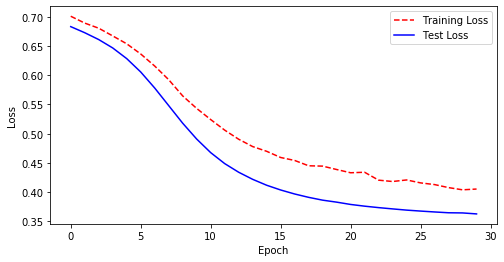

In [51]:
# Get training and test loss histories
training_loss = history['loss']
test_loss = history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(x, training_loss, 'r--')
plt.plot(x, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

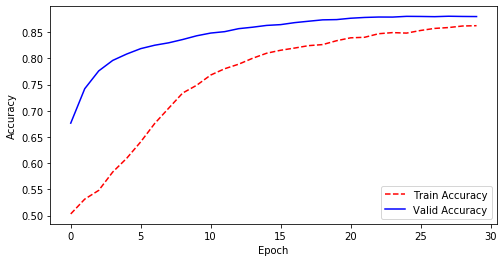

In [52]:
# Get training and test loss histories
training_accuracy = history["acc"]
validation_accuracy = history["val_acc"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(x, training_accuracy, 'r--')
plt.plot(x, validation_accuracy, 'b-')
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Model Evaluation

In [37]:
train["probability"] = model.predict(trainX)
train["prediction"] = train.probability-0.5>0
train["truth"] = train.label==1
train.tail()

,review,label,file,probability,prediction,truth
2455,I saw this when I was 17 and haven't seen it s...,1,2232_7.txt,0.817723,True,True
1043,Somerset Maugham's characters are brought to l...,1,12121_7.txt,0.810066,True,True
17166,Five Across the Eyes starts as five young teen...,0,8217_1.txt,0.176918,False,False
24532,A remake of the superb 1972 movie of the stage...,0,4756_3.txt,0.361655,False,False
23170,For anyone craving a remake of 1989's Slaves o...,0,393_2.txt,0.183589,False,False


In [38]:
print(model.evaluate(trainX, trainY))
print((train.truth==train.prediction).mean())

15000/15000 [==============================] - 3s 207us/sample - loss: 0.3207 - acc: 0.9169
[0.32065588642756143, 0.91686666]
0.9168666666666667


In [39]:
valid["probability"] = model.predict(validX)
valid["prediction"] = valid.probability-0.5>0
valid["truth"] = valid.label==1
valid.tail()

,review,label,file,probability,prediction,truth
8087,It's amazing that actress P.J. Soles didn't be...,1,737_8.txt,0.820333,True,True
11702,This is what we can do to each other. This is ...,1,6487_10.txt,0.788725,True,True
1056,"***Might not consider this having a spoiler, b...",1,2889_10.txt,0.818268,True,True
13081,It's just breathtaking in it's awfulness-- you...,0,4110_1.txt,0.597968,True,False
3811,This series could very well be the best Britco...,1,10854_10.txt,0.821569,True,True


In [40]:
print(model.evaluate(validX, validY))
print((valid.truth==valid.prediction).mean())

10000/10000 [==============================] - 2s 203us/sample - loss: 0.3627 - acc: 0.8799
[0.3627273031234741, 0.8799]
0.8799


#### Error Analysis

In [41]:
trainCross = train.groupby(["prediction", "truth"]).size().unstack()
trainCross

truth,False,True
prediction,,
False,6852,569
True,678,6901


In [42]:
validCross = valid.groupby(["prediction", "truth"]).size().unstack()
validCross

truth,False,True
prediction,,
False,4340,571
True,630,4459


In [43]:
truepositives = valid[(valid.truth==True)&(valid.truth==valid.prediction)]
print(len(truepositives), "true positives.")
truepositives.sort_values("probability", ascending=False).head(3)

4459 true positives.


,review,label,file,probability,prediction,truth
5422,One of the best movies out there. Yeah maybe t...,1,8376_10.txt,0.822717,True,True
2508,This movie was incredible. I would recommend i...,1,1857_10.txt,0.822693,True,True
12184,If you have not seen this excellent movie abou...,1,4312_10.txt,0.822680,True,True


In [44]:
truenegatives = valid[(valid.truth==False)&(valid.truth==valid.prediction)]
print(len(truenegatives), "true negatives.")
truenegatives.sort_values("probability", ascending=True).head(3)

4340 true negatives.


,review,label,file,probability,prediction,truth
19412,I tried as hard as I could to sit all the way ...,0,9735_1.txt,0.176783,False,False
20451,"Lame, lame, lame!!! A 90-minute cringe-fest th...",0,10879_1.txt,0.176803,False,False
23967,I hated this movie. It was absolutely horrible...,0,12427_1.txt,0.176805,False,False


In [45]:
falsepositives = valid[(valid.truth==True)&(valid.truth!=valid.prediction)]
print(len(falsepositives), "false positives.")
falsepositives.sort_values("probability", ascending=True).head(3)

571 false positives.


,review,label,file,probability,prediction,truth
11593,"Actually I liked this movie very, very much. N...",1,5230_10.txt,0.177151,False,True
3919,This movie has everything that makes a bad mov...,1,4185_8.txt,0.177340,False,True
4552,Verhoeven's movie was utter and complete garba...,1,1005_10.txt,0.177744,False,True


In [46]:
falsenegatives = valid[(valid.truth==False)&(valid.truth!=valid.prediction)]
print(len(falsenegatives), "false negatives.")
falsenegatives.sort_values("probability", ascending=False).head(3)

630 false negatives.


,review,label,file,probability,prediction,truth
18283,The beginning of this movie is excellent with ...,0,4212_4.txt,0.821682,True,False
13462,I've almost forever been against the inclusion...,0,2355_3.txt,0.821608,True,False
22191,"Time travel is a fun concept, and this film gi...",0,3677_3.txt,0.820584,True,False


In [47]:
HTML(valid.loc[22148].review)

In [48]:
unseen = pd.Series("this movie very good")

In [49]:
unseen = preprocess.transform(unseen)       # Text preprocessing
unseen = tfidf.transform(unseen).toarray()  # Feature engineering
unseen = unseen[:,bestIndeces]              # Feature selection
probability = model.predict(unseen)[0,0]  # Network feedforward

Transformed.


In [50]:
print(probability)
print("Positive!") if probability > 0.5 else print("Negative!")

0.74318516
Positive!


In [54]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir,'train')
test_dir = os.path.join(imdb_dir,'test')
train_labels = []
train_texts = []

test_labels = []
test_texts = []

In [55]:
for label_type in ['pos','neg']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname))
            train_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)

In [56]:
for label_type in ['pos','neg']:
    dir_name = os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname))
            test_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)

In [57]:
texts_df = pd.DataFrame({'texts': train_texts,
                        'labels':train_labels})

In [58]:
texts_df['word counts'] = texts_df['texts'].apply(lambda x: len(x.split()))

In [59]:
texts_df.head()

,texts,labels,word counts
0,For a movie that gets no respect there sure ar...,1,52
1,Bizarre horror movie filled with famous faces ...,1,166
2,"A solid, if unremarkable film. Matthau, as Ein...",1,55
3,It's a strange feeling to sit alone in a theat...,1,442
4,"You probably all already know this by now, but...",1,144


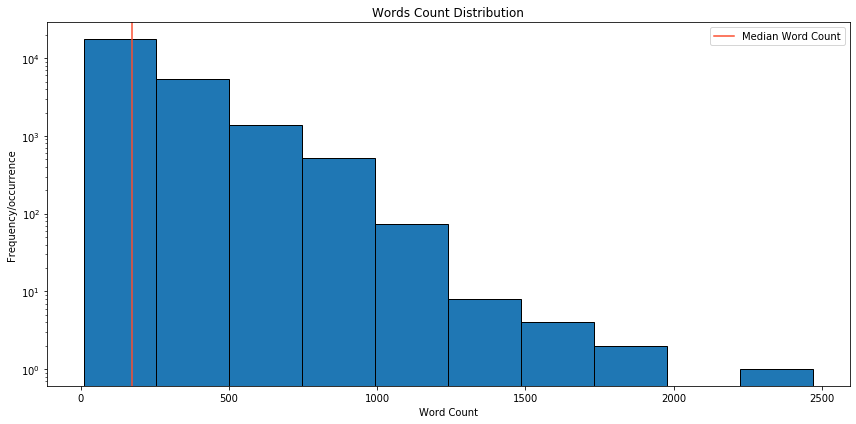

In [60]:
median_word_count = median(texts_df['word counts'])
plt.figure(figsize=(12,6))
plt.hist(texts_df['word counts'],edgecolor='black',log=True)
plt.title("Words Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency/occurrence")

color = '#fc4f30'

plt.axvline(median_word_count,color=color,label="Median Word Count")
plt.legend()
plt.tight_layout()

In [61]:
my_stop_words = ENGLISH_STOP_WORDS.union(["br","movie","film"])
count_vect = CountVectorizer(stop_words=my_stop_words)
bag_of_words = count_vect.fit_transform(texts_df['texts'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [62]:
top_30_words = words_freq[:30]
top_word_list = []
top_count_list = []
for item in top_30_words:
    top_word_list.append(item[0])
    top_count_list.append(item[1])

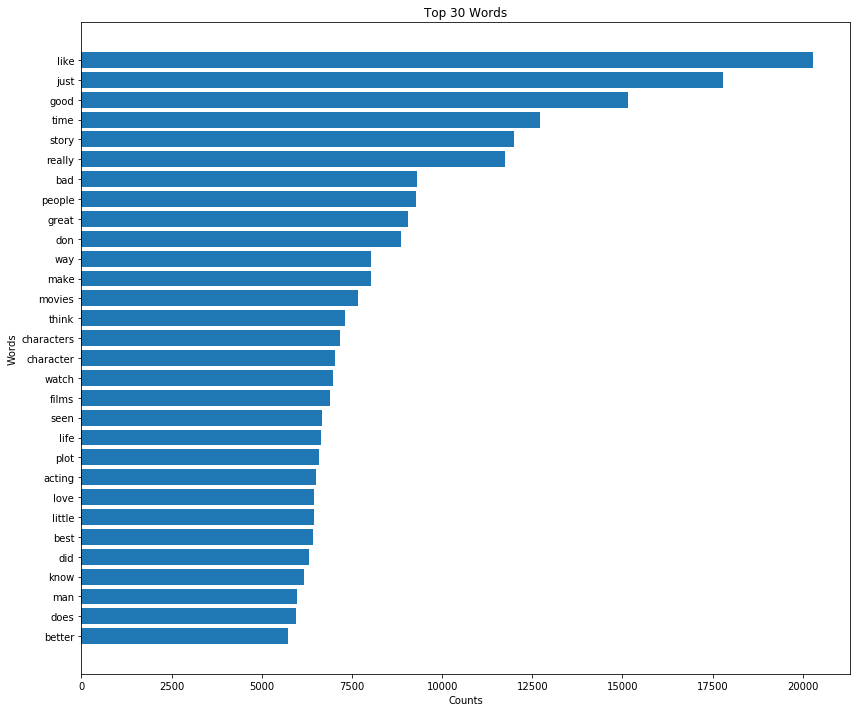

In [63]:
top_word_list.reverse()
top_count_list.reverse()
plt.figure(figsize=(12,10))
plt.barh(top_word_list,top_count_list)
plt.title("Top 30 Words")
plt.xlabel("Counts")
plt.ylabel("Words")
plt.tight_layout()

In [64]:
positive = texts_df[texts_df['labels']==1]['texts']
negative = texts_df[texts_df['labels']==0]['texts']

<Figure size 432x288 with 0 Axes>

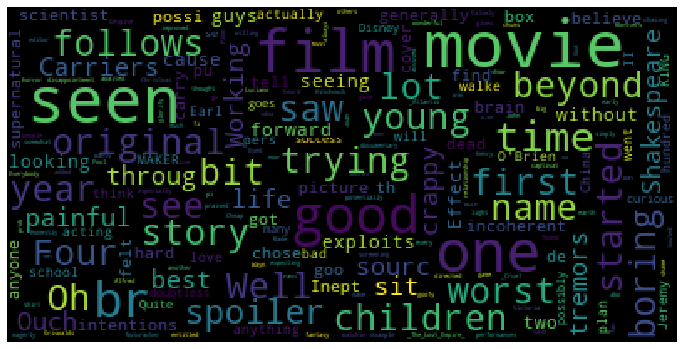

In [66]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='black',
                      stopwords=stopwords,
                      max_words=200,
                      max_font_size=40, 
                      random_state=42
                      ).generate(str(negative))

print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word.png", dpi=900)

In [67]:
MAX_LENGTH = 500
MAX_WORDS = 20000
EMBENDING_DIM = 100

In [68]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

In [69]:
word_index = tokenizer.word_index

In [70]:
print(f'Found {len(word_index)} unique tokens.' )

Found 88582 unique tokens.


In [71]:
data = pad_sequences(sequences,maxlen=MAX_LENGTH)
labels = np.array(train_labels)

In [72]:
X_train, X_val, y_train, y_val = train_test_split(data,labels,test_size=0.2,random_state=42)

In [73]:
glove_dir = "glove-global-vectors-for-word-representation/glove.6B.100d.txt"
embedding_index = {}
f = open(glove_dir)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [74]:
embedding_index['go'][:10]

array([-0.078894,  0.4616  ,  0.57779 , -0.71637 , -0.13121 ,  0.4186  ,
       -0.29156 ,  0.52006 ,  0.089986, -0.35062 ], dtype=float32)

In [75]:
embedding_matrix = np.zeros((MAX_WORDS,EMBENDING_DIM))

In [76]:
for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [77]:
embedding_df = pd.DataFrame(embedding_matrix)

In [78]:
embedding_df.shape

(20000, 100)

In [79]:
model = models.Sequential()
model.add(layers.Embedding(MAX_WORDS,EMBENDING_DIM, input_length=MAX_LENGTH))
model.add(layers.LSTM(32))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,017,057
Trainable params: 2,017,057
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [81]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=2,
                    batch_size=32,
                    validation_data=(X_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 291s 15ms/step - loss: 0.5658 - acc: 0.7047 - val_loss: 0.4618 - val_acc: 0.7844
Epoch 2/2
20000/20000 [==============================] - 267s 13ms/step - loss: 0.4211 - acc: 0.8129 - val_loss: 0.3693 - val_acc: 0.8418


In [82]:
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences,maxlen=MAX_LENGTH)
test_labels = np.array(test_labels)

In [83]:
predictions = model.predict(test_data)

In [84]:
pred_proba = model.predict_proba(test_data)

In [85]:
pred_labels  = (predictions>0.5)

Text(15.380000000000003, 0.5, 'predicted label')

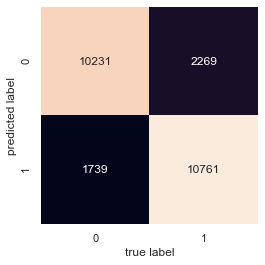

In [86]:
mat = confusion_matrix(pred_labels, test_labels)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [87]:
print(classification_report(test_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     12500
           1       0.83      0.86      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



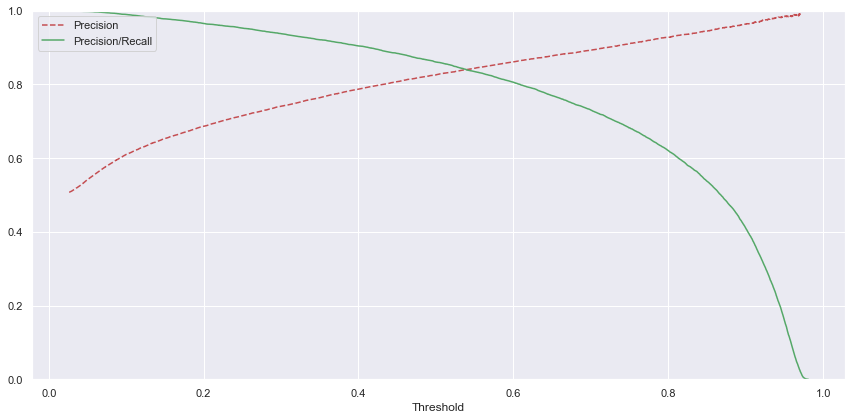

In [88]:
precisions, recalls, thresholds = precision_recall_curve(test_labels,pred_proba)
plt.figure(figsize=(12,6))
plt.plot(thresholds, precisions[:-1], "r--",label='Precision')
plt.plot(thresholds, recalls[:-1],"g-",label="Precision/Recall")
plt.xlabel("Threshold")
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.tight_layout()

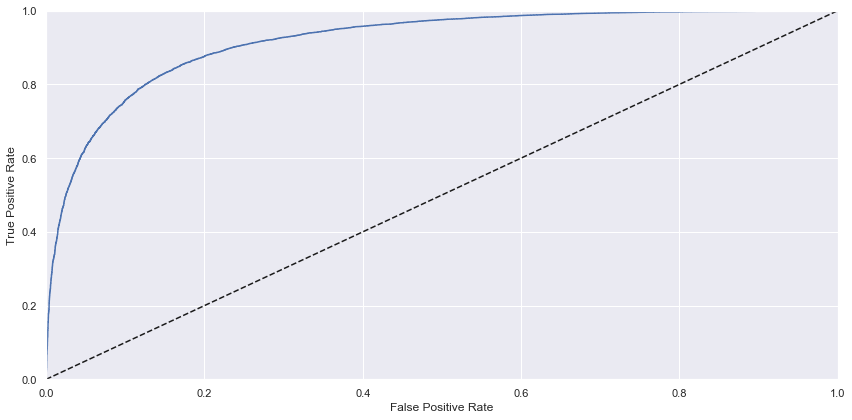

In [89]:
fpr,tpr, thresholds = roc_curve(test_labels,pred_proba)
plt.figure(figsize=(12,6))
plt.plot(fpr,tpr, label=None)
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1,0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()